In [131]:
# Libraries
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from helperfunctions import kfold_cross_validation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
from IPython.core.interactiveshell import InteractiveShell

# Notebook Settings 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("error")
pd.set_option('display.max_columns', 500)
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Variables
crop_seasons = list(range(1993,2017))
months_of_crop_season = list(range(4,12))
homogeneous_groups = list(range(1,5))
models = ["ECMWF", "NCEP", "UKMO", "MME", "CLIMATE", "WS"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Read Data

In [100]:
kfold_cv_dataset = pd.read_csv("kfold_cv_dataset.csv")

## 2. Simulate wheat yield

In [101]:
def perform_simulations_and_compute_metrics(df):
    rmse_scores = pd.DataFrame(0, index=models, columns=months_of_crop_season)
    r2_scores = pd.DataFrame(0, index=models, columns=months_of_crop_season)
    simulations = []
    for month in months_of_crop_season:
        for model in models:
            res = kfold_cross_validation(df, model=model, init=month, no_of_features=8)
            res = res.assign(model=model, init_month=month)
            simulations.append(res)
            # rmse
            rmse_score = 100 * mse(res["yield"], res["predicted"], squared=False)/(res["yield"].mean())
            rmse_scores.loc[model, month] = np.round(rmse_score, 2)
            # coefficient of determination
            r2_score = r2(res["yield"], res["predicted"])
            r2_scores.loc[model, month] = np.round(r2_score, 2)
    
    simulations = pd.concat(simulations, ignore_index=False, axis=0)    
    return (simulations, rmse_scores, r2_scores)

In [102]:
simulations, rmse_scores, r2_scores = perform_simulations_and_compute_metrics(kfold_cv_dataset)

In [111]:
simulations.sample(2)
rmse_scores.head(5)
r2_scores.head(5)

,year,predicted,yield,model,init_month
8,2001,2563.173261,2737.790335,ECMWF,11
13,2006,2794.989314,2066.527125,UKMO,4


,4,5,6,7,8,9,10,11
ECMWF,11.56,11.90,11.23,11.44,10.58,9.49,7.88,6.01
NCEP,14.34,14.88,14.70,12.74,11.84,10.45,9.26,6.01
UKMO,12.28,12.71,10.79,12.13,11.07,10.61,7.64,6.01
MME,12.12,12.47,11.76,11.62,10.47,9.86,7.90,6.01
CLIMATE,11.75,11.75,11.75,11.75,11.75,10.27,9.13,6.01


,4,5,6,7,8,9,10,11
ECMWF,-0.05,-0.12,0.01,-0.03,0.12,0.29,0.51,0.72
NCEP,-0.62,-0.75,-0.70,-0.28,-0.10,0.14,0.32,0.72
UKMO,-0.19,-0.27,0.08,-0.16,0.03,0.11,0.54,0.72
MME,-0.16,-0.23,-0.09,-0.06,0.14,0.23,0.51,0.72
CLIMATE,-0.09,-0.09,-0.09,-0.09,-0.09,0.17,0.34,0.72


### 3. Visualizations
#### 3.1 RMSE and R2 development

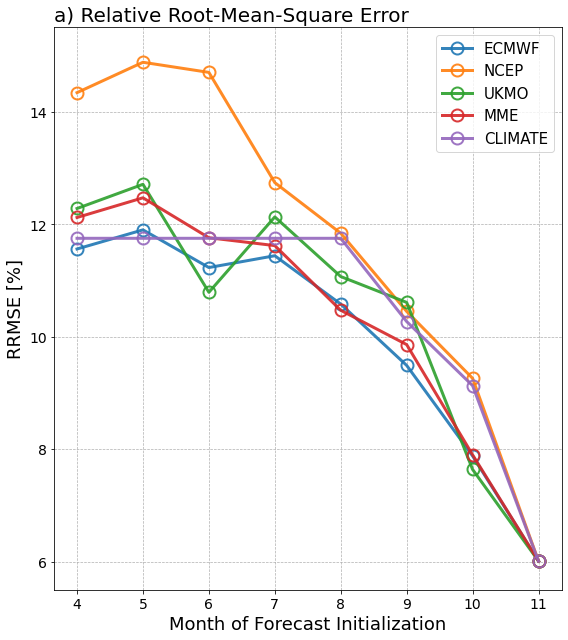

In [107]:
ax = rmse_scores.loc[rmse_scores.index != "WS"].transpose().plot(figsize=(8,9), 
                                                                 marker='o', 
                                                                 ms=12, 
                                                                 lw=3, 
                                                                 linestyle='-', 
                                                                 alpha=.9, 
                                                                 markerfacecolor='none',
                                                                 markeredgewidth=2.0, legend=False)
ax.grid('on', which='both', axis='y', linestyle='--', linewidth=.7)
ax.grid('on', which='both', axis='x', linestyle='--', linewidth=.7)
ax.set_xlabel('Month of Forecast Initialization', fontsize=18)
#ax.set_ylabel(r'$R^{2}$', fontsize=18)
ax.set_ylabel('RRMSE [%]', fontsize=18)
ax.set_title('a) Relative Root-Mean-Square Error', loc="left", fontsize=20)
#ax.set_title('b) Coefficient of Determination', loc="left", fontsize=20)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(fontsize=15)
ax.set_ylim(5.5, 15.5)
#ax.set_ylim(-0.85, 0.85)
plt.tight_layout()
#plt.savefig("images/rmsescore_development.png", dpi=1000)
plt.show();

#### 3.2 Graphical Analysis of residuals

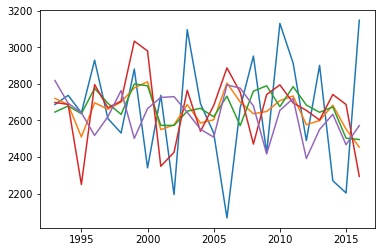

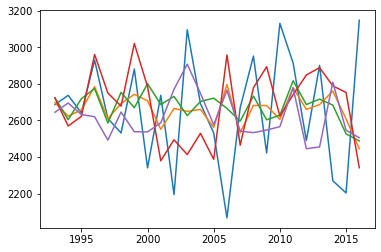

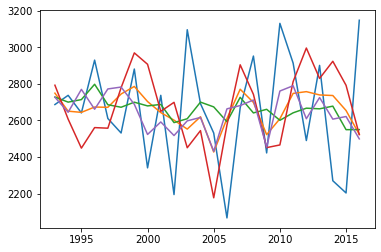

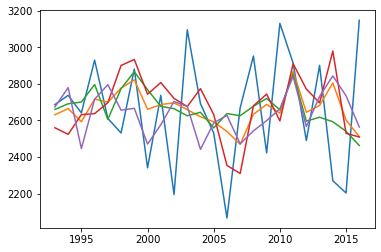

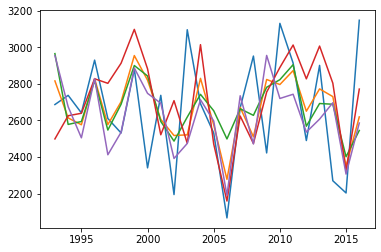

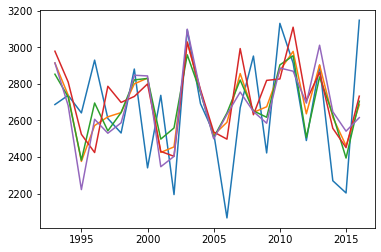

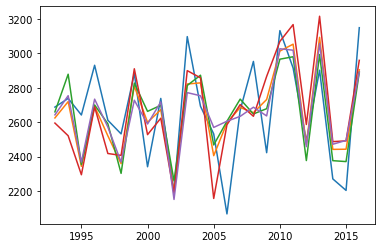

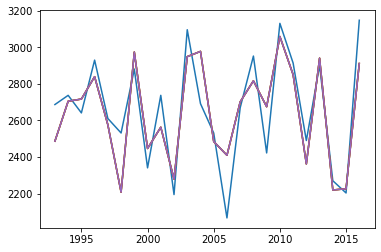

In [134]:
for month in months_of_crop_season:
    sims_plot = simulations.loc[(simulations["init_month"] == month) & (simulations["model"].isin(["MME", "ECMWF", "NCEP", "UKMO"])), ["year", "model", "predicted"]].set_index("model")
    ground_truth_plot = simulations.loc[(simulations["init_month"] == month) & (simulations["model"] == "WS"), ["year", "model", "yield"]]
    
    plt.plot(ground_truth_plot["year"], ground_truth_plot["yield"])
    plt.plot(sims_plot.loc["MME", "year"], sims_plot.loc["MME", "predicted"])
    plt.plot(sims_plot.loc["ECMWF", "year"], sims_plot.loc["ECMWF", "predicted"])
    plt.plot(sims_plot.loc["NCEP", "year"], sims_plot.loc["NCEP", "predicted"])
    plt.plot(sims_plot.loc["UKMO", "year"], sims_plot.loc["UKMO", "predicted"])

    #plt.legend(['y = x', 'y = 2x', 'y = 3x', 'y = 4x'], loc='upper left')

    plt.show();